# tabular-playground-series-jan-2022 Modeling
- データに関する知見だけでなく、データ分析の基礎的な方法をコメントで残す形とする

## 1. Import libralies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, GroupKFold, learning_curve, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

sns.set(style='white', context='notebook', palette='pastel')

In [2]:
from keras.models import Model
from keras.layers import Dense, Input, InputLayer, Add
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TerminateOnNaN
from keras import optimizers

import tensorflow as tf

from tensorflow.keras.optimizers import Adam

## 2. Load processed data

In [3]:
# Load data
#train = pd.read_csv('../data/processed/train_v1_label.csv', index_col=0)
#test = pd.read_csv('../data/processed/test_v1_label.csv', index_col=0)
#train = pd.read_csv('../data/processed/train_v2_onehot.csv', index_col=0)
#test = pd.read_csv('../data/processed/test_v2_onehot.csv', index_col=0)
#train = pd.read_csv('../data/processed/train_v3_onehot_economy.csv', index_col=0)
#test = pd.read_csv('../data/processed/test_v3_onehot_economy.csv', index_col=0)
train = pd.read_csv('../data/processed/train_v4_onehot_holiday.csv', index_col=0)
test = pd.read_csv('../data/processed/test_v4_onehot_holiday.csv', index_col=0)

In [4]:
train.head()

,num_sold,year,month,day,dayofweek,Christmas,NewYear,Easter,Pentecost,country_0,country_1,country_2,store_0,store_1,product_0,product_1,product_2
0,329.0,2015,1,1,3,0,1,0,0,1,0,0,1,0,0,1,0
1,520.0,2015,1,1,3,0,1,0,0,1,0,0,1,0,1,0,0
2,146.0,2015,1,1,3,0,1,0,0,1,0,0,1,0,0,0,1
3,572.0,2015,1,1,3,0,1,0,0,1,0,0,0,1,0,1,0
4,911.0,2015,1,1,3,0,1,0,0,1,0,0,0,1,1,0,0


In [5]:
def preprocess_dataset(df):
    """Preprocess the data (select columns and scale)
    ### MinMaxScaler: 正規化（値を0~1の範囲に）
    ### RobustScalar: 正規化（ただし、四分位範囲を分母とする）
    ### StandardScaler: 標準化（平均との差をとり標準偏差で割る）
    """
    # preproc = make_pipeline(MinMaxScaler(), StandardScaler(with_std=False))
    preproc = make_pipeline(RobustScaler(), StandardScaler(with_std=False))
    df_f = pd.DataFrame(preproc.fit_transform(df), columns=df.columns, index=df.index)

    return df_f

def normalize_dataset(df):
    """Preprocess the data (select columns and scale)
    ### MinMaxScaler: 正規化（値を0~1の範囲に）
    """
    preproc = make_pipeline(MinMaxScaler())
    df_f = pd.DataFrame(preproc.fit_transform(df), columns=df.columns, index=df.index)

    return df_f

def standardize_dataset(df):
    """Preprocess the data (select columns and scale)
    ### StandardScaler: 標準化（平均との差をとり標準偏差で割る）
    """
    preproc = make_pipeline(StandardScaler(with_std=False))
    df_f = pd.DataFrame(preproc.fit_transform(df), columns=df.columns, index=df.index)

    return df_f

In [6]:
train['num_sold'] = train['num_sold'].astype(int)

#train = preprocess_dataset(train)
#print(train.head())

train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# preprocessed_columns = ['num_sold', 'year', 'month', 'day', 'dayofweek']
# dataset[preprocessed_columns] = preprocess_dataset(dataset[preprocessed_columns])

normlized_columns = ['year', 'month', 'day', 'dayofweek']
standarized_columns = ['num_sold']

dataset[normlized_columns] = normalize_dataset(dataset[normlized_columns])
#dataset[standarized_columns] = standardize_dataset(dataset[standarized_columns])
#dataset[standarized_columns] = preprocess_dataset(dataset[standarized_columns])


train = dataset[:train_len]
test = dataset[train_len:]

Y_train = train['num_sold']
X_train = train.drop(columns=['num_sold'])

"""
train['num_sold_base'] = train['num_sold_base'].astype(int)
Y_train = train['num_sold_base']
X_train = train.drop(columns=['num_sold', 'num_sold_base'])
"""
raw_test = pd.read_csv("../data/raw/test.csv")
test_id = raw_test['row_id']

In [7]:
train.head()

,num_sold,year,month,day,dayofweek,Christmas,NewYear,Easter,Pentecost,country_0,country_1,country_2,store_0,store_1,product_0,product_1,product_2
0,329.0,0.0,0.0,0.0,0.5,0,1,0,0,1,0,0,1,0,0,1,0
1,520.0,0.0,0.0,0.0,0.5,0,1,0,0,1,0,0,1,0,1,0,0
2,146.0,0.0,0.0,0.0,0.5,0,1,0,0,1,0,0,1,0,0,0,1
3,572.0,0.0,0.0,0.0,0.5,0,1,0,0,1,0,0,0,1,0,1,0
4,911.0,0.0,0.0,0.0,0.5,0,1,0,0,1,0,0,0,1,1,0,0


In [8]:
train.tail()

,num_sold,year,month,day,dayofweek,Christmas,NewYear,Easter,Pentecost,country_0,country_1,country_2,store_0,store_1,product_0,product_1,product_2
26293,823.0,0.75,1.0,1.0,0.0,1,0,0,0,0,0,1,1,0,1,0,0
26294,250.0,0.75,1.0,1.0,0.0,1,0,0,0,0,0,1,1,0,0,0,1
26295,1004.0,0.75,1.0,1.0,0.0,1,0,0,0,0,0,1,0,1,0,1,0
26296,1441.0,0.75,1.0,1.0,0.0,1,0,0,0,0,0,1,0,1,1,0,0
26297,388.0,0.75,1.0,1.0,0.0,1,0,0,0,0,0,1,0,1,0,0,1


In [9]:
Y_train.head()

0    329.0
1    520.0
2    146.0
3    572.0
4    911.0
Name: num_sold, dtype: float64

## 3. Training Setting

### 3.1 define setting parameters
Cross validate models

In [10]:
# 再現性確保のためのrandom_state の設定
random_state = 43

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

### 3.2 define evaluation

In [11]:
def calc_smape_score(true, pred):
    """SMAPEを計算する

    true (np.array) : 実測値
    pred (np.array) : 予測値

    np.array        : smapeの計算結果
    """

    return 100 / len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(pred) + np.abs(true)))


In [12]:
def smape_loss(true, pred):
    return 100 / len(true) * tf.sum(2 * tf.abs(pred - true) / (tf.abs(pred) + tf.abs(true)))

In [13]:
scoring_smape = make_scorer(calc_smape_score, greater_is_better=False)

score_funcs = {
    'smape': scoring_smape,
    'R2': make_scorer(r2_score, greater_is_better=True),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
}

### 3.3 split datasets

## 4. Modeling

### 4.1 model setting

In [28]:
def simple_model(input_dim):
    """simple linear model

    The model is to be used with a log-transformed target.
    """
    x = Input(shape=(input_dim))
    z = Dense(32, use_bias=True)(x)
    output = Dense(1, use_bias=True)(z)
    model = Model(x, output)

    return model

In [30]:
def setting_callbacks():
    # Define the learning rate schedule and EarlyStopping
    if True:
        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7,
                               patience=150, verbose=1)
        es = EarlyStopping(monitor="val_loss",
                           patience=300,
                           verbose=1,
                           mode="min",
                           restore_best_weights=True)
        callbacks = [lr, es, TerminateOnNaN()]

    else:
        epochs = EPOCHS_COSINEDECAY
        lr_start=0.02
        lr_end=0.00001
        def cosine_decay(epoch):
            if epochs > 1:
                w = (1 + math.cos(epoch / (epochs-1) * math.pi)) / 2
            else:
                w = 1
            return w * lr_start + (1 - w) * lr_end

        lr = LearningRateScheduler(cosine_decay, verbose=0)
        callbacks = [lr, TerminateOnNaN()]

    return callbacks

In [16]:
def setting_epochs():
    # Define the learning rate schedule and EarlyStopping
    if USE_PLATEAU and X_va is not None:
        epochs = EPOCHS

    else:
        epochs = EPOCHS_COSINEDECAY
        lr_start=0.02
        lr_end=0.00001
        def cosine_decay(epoch):
            if epochs > 1:
                w = (1 + math.cos(epoch / (epochs-1) * math.pi)) / 2
            else:
                w = 1
            return w * lr_start + (1 - w) * lr_end

    return callbacks

In [17]:
# Plot training history
def plot_history(history, *, n_epochs=None, plot_lr=False, plot_acc=True, title=None, bottom=None, top=None):
    """Plot (the last n_epochs epochs of) the training history
    """
    plt.figure(figsize=(15, 6))

    if n_epochs is None:
        from_epoch = 0
    else:
        from_epoch = max(len(history['loss']) - n_epochs, 0)

    # Plot training and validation losses
    plt.plot(np.arange(from_epoch, len(history['loss'])), history['loss'][from_epoch:], label='Training loss')
    plt.plot(np.arange(from_epoch, len(history['loss'])), history['val_loss'][from_epoch:], label='Validation loss')


    best_epoch = np.argmin(np.array(history['val_loss']))
    best_val_loss = history['val_loss'][best_epoch]


    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_loss], c='r', label=f'Best val_loss = {best_val_loss:.5f}')
    if best_epoch > 0:
        almost_epoch = np.argmin(np.array(history['val_loss'])[:best_epoch])
        almost_val_loss = history['val_loss'][almost_epoch]
        if almost_epoch >= from_epoch:
            plt.scatter([almost_epoch], [almost_val_loss], c='orange', label='Second best val_loss')


    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')

    if bottom is not None:
        plt.ylim(bottom=bottom)
    if top is not None:
        plt.ylim(top=top)
    if title is not None:
        plt.title(title)

    # Plot learning rate
    if plot_lr and 'lr' in history:
        ax2 = plt.gca().twinx()
        ax2.plot(np.arange(from_epoch, len(history['lr'])), np.array(history['lr'][from_epoch:]), color='g', label='Learning rate')
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc='upper right')

    plt.show()

In [18]:
def plot_prediction_scatter(true, pred):

    # Plot y_true vs. y_pred
    plt.figure(figsize=(10, 10))
    plt.scatter(true, pred, s=1, color='r')
    #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')

    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()


In [25]:
def training_model(x_train, y_train, x_val, y_val, X_va=None):
    """Scale the data, fit a model, plot the training history and validate the model"""

    # Construct and compile the model
    model = simple_model(len(x_train.columns))
    print(model.summary())
    #model.compile(loss='mse', metrics=smape_loss)
    #model.compile(loss='mse')
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    #model.compile(optimizer=optimizers.adam(learning_rate=0.01), loss='mse')
    #model.compile(optimizer=optimizers.SGD(), loss='mse')

    callbacks = setting_callbacks()

    # Train the model
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        batch_size=512,
                        epochs=5000,
                        verbose=1,
                        callbacks=callbacks,
                        shuffle=True)

    if X_va is not None:
        # Inference for validation
        y_va_pred = np.exp(model.predict([X_va_f[features]]))
        oof_list[run][val_idx] = y_va_pred

        # Evaluation: Execution time and SMAPE
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f} validated on {X_va.iloc[0].date.year}")
        score_list.append(smape)

    return model, history.history


In [26]:
def predict_model(model, x):
    pred = model.predict(x)
    pred = pred.reshape(-1)
    return pred

In [31]:
# Make the results reproducible
RUNS = 2

history_list, score_list, test_pred_list = [], [], []
oof_list = [np.full((len(train), 1), -1.0, dtype='float32') for run in range(RUNS)]

for run in range(RUNS):
    model = None

    kf = GroupKFold(n_splits=2)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=train.year)):
        x_train = X_train.iloc[train_idx]
        y_train = Y_train.iloc[train_idx]
        x_val = X_train.iloc[val_idx]
        y_val = Y_train.iloc[val_idx]

        print(f"Fold {run}.{fold}")
        model, history = training_model(x_train, y_train, x_val, y_val)

        val_pred = predict_model(model, x_val)
        #print(y_val)
        #print(val_pred)
        score = calc_smape_score(y_val, val_pred)
        score_list.append(score)
        history_list.append(history)
        print(f"run-fold: {run}-{fold} SMAPE: {score:.5f}")

print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f}") # Average over all runs and folds

#with open('oof.pickle', 'wb') as handle: pickle.dump(oof_list, handle) # for further analysis

#if RUNS > 1:
#    y_va = train_df.num_sold
#    print(f"Ensemble SMAPE: {np.mean(smape_loss(y_va, sum(oof_list).ravel() / len(oof_list))):.5f}")
#print(f"Total time: {str(datetime.now() - total_start_time)[:-7]}")

Fold 0.0
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5000


/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


26/26 [==============================] - 0s 6ms/step - loss: 239626.4062 - val_loss: 178187.2188 - lr: 0.0100
Epoch 2/5000
26/26 [==============================] - 0s 2ms/step - loss: 206683.1562 - val_loss: 139549.1406 - lr: 0.0100
Epoch 3/5000
26/26 [==============================] - 0s 3ms/step - loss: 150141.4844 - val_loss: 91189.8047 - lr: 0.0100
Epoch 4/5000
26/26 [==============================] - 0s 3ms/step - loss: 97555.8750 - val_loss: 60766.9492 - lr: 0.0100
Epoch 5/5000
26/26 [==============================] - 0s 3ms/step - loss: 70870.8984 - val_loss: 49020.8320 - lr: 0.0100
Epoch 6/5000
26/26 [==============================] - 0s 3ms/step - loss: 59322.8320 - val_loss: 40994.6562 - lr: 0.0100
Epoch 7/5000
26/26 [==============================] - 0s 3ms/step - loss: 50361.4336 - val_loss: 33929.3008 - lr: 0.0100
Epoch 8/5000
26/26 [==============================] - 0s 3ms/step - loss: 42507.9297 - val_loss: 27851.4141 - lr: 0.0100
Epoch 9/5000
26/26 [====================

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


26/26 [==============================] - 0s 6ms/step - loss: 189476.0156 - val_loss: 230524.2188 - lr: 0.0100
Epoch 2/5000
26/26 [==============================] - 0s 3ms/step - loss: 164511.7188 - val_loss: 184281.8750 - lr: 0.0100
Epoch 3/5000
26/26 [==============================] - 0s 3ms/step - loss: 118832.6953 - val_loss: 122359.4531 - lr: 0.0100
Epoch 4/5000
26/26 [==============================] - 0s 3ms/step - loss: 75974.0312 - val_loss: 80942.8203 - lr: 0.0100
Epoch 5/5000
26/26 [==============================] - 0s 3ms/step - loss: 54488.4648 - val_loss: 64392.1445 - lr: 0.0100
Epoch 6/5000
26/26 [==============================] - 0s 3ms/step - loss: 45010.7852 - val_loss: 54677.5859 - lr: 0.0100
Epoch 7/5000
26/26 [==============================] - 0s 2ms/step - loss: 37551.9961 - val_loss: 46567.6953 - lr: 0.0100
Epoch 8/5000
26/26 [==============================] - 0s 3ms/step - loss: 31118.0234 - val_loss: 39453.6484 - lr: 0.0100
Epoch 9/5000
26/26 [===================

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


26/26 [==============================] - 0s 6ms/step - loss: 239871.0781 - val_loss: 178388.1719 - lr: 0.0100
Epoch 2/5000
26/26 [==============================] - 0s 2ms/step - loss: 207345.7031 - val_loss: 139608.5312 - lr: 0.0100
Epoch 3/5000
26/26 [==============================] - 0s 3ms/step - loss: 150795.3594 - val_loss: 90978.6328 - lr: 0.0100
Epoch 4/5000
26/26 [==============================] - 0s 3ms/step - loss: 97720.6719 - val_loss: 60634.0430 - lr: 0.0100
Epoch 5/5000
26/26 [==============================] - 0s 3ms/step - loss: 71125.0234 - val_loss: 49042.0977 - lr: 0.0100
Epoch 6/5000
26/26 [==============================] - 0s 3ms/step - loss: 59461.2734 - val_loss: 41301.7578 - lr: 0.0100
Epoch 7/5000
26/26 [==============================] - 0s 3ms/step - loss: 50688.9492 - val_loss: 34234.6484 - lr: 0.0100
Epoch 8/5000
26/26 [==============================] - 0s 3ms/step - loss: 42855.7383 - val_loss: 28151.9941 - lr: 0.0100
Epoch 9/5000
26/26 [====================

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


26/26 [==============================] - 0s 6ms/step - loss: 188719.5625 - val_loss: 228469.5000 - lr: 0.0100
Epoch 2/5000
26/26 [==============================] - 0s 3ms/step - loss: 163277.8281 - val_loss: 181691.9062 - lr: 0.0100
Epoch 3/5000
26/26 [==============================] - 0s 3ms/step - loss: 117871.5391 - val_loss: 120625.2891 - lr: 0.0100
Epoch 4/5000
26/26 [==============================] - 0s 2ms/step - loss: 75529.7656 - val_loss: 80208.6562 - lr: 0.0100
Epoch 5/5000
26/26 [==============================] - 0s 3ms/step - loss: 54425.1797 - val_loss: 64112.7891 - lr: 0.0100
Epoch 6/5000
26/26 [==============================] - 0s 3ms/step - loss: 44801.0898 - val_loss: 54451.8008 - lr: 0.0100
Epoch 7/5000
26/26 [==============================] - 0s 2ms/step - loss: 37357.5312 - val_loss: 46145.5781 - lr: 0.0100
Epoch 8/5000
26/26 [==============================] - 0s 3ms/step - loss: 30851.2070 - val_loss: 38991.5195 - lr: 0.0100
Epoch 9/5000
26/26 [===================

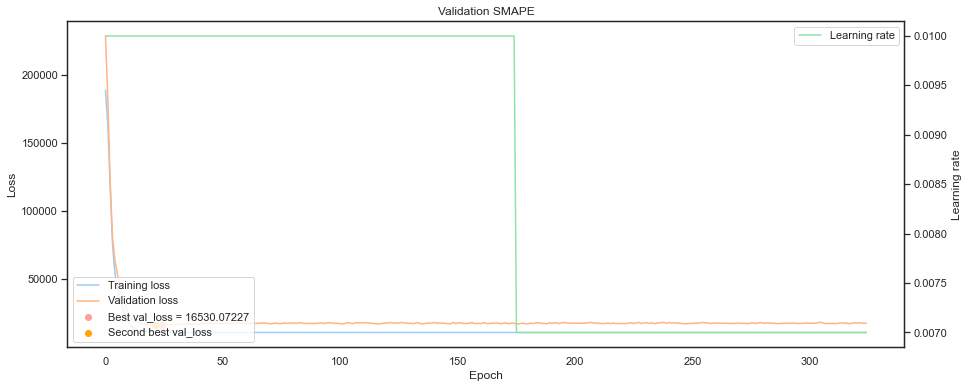

In [32]:
# Plot training history
plot_history(history_list[-1], title=f"Validation SMAPE", plot_lr=True, n_epochs=5000)

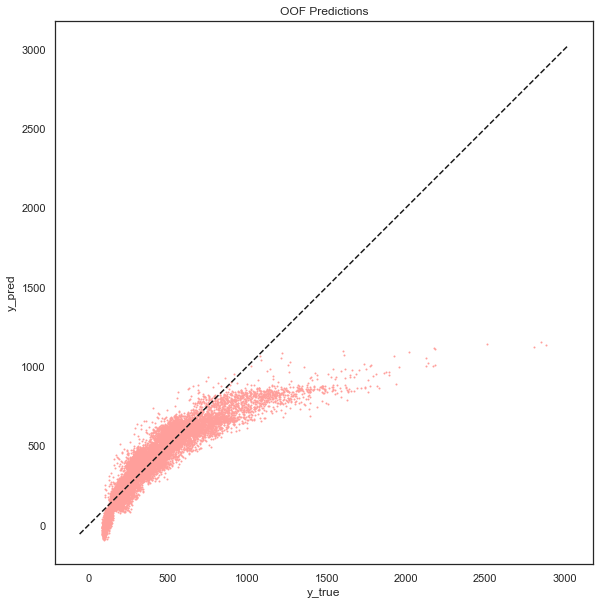

In [33]:
plot_prediction_scatter(y_val, val_pred)

In [ ]:
# Plot all num_sold_true and num_sold_pred (five years) for one country-store-product combination
def plot_five_years_combination(engineer, country='Norway', store='KaggleMart', product='Kaggle Hat'):
    demo_df = pd.DataFrame({'row_id': 0,
                            'date': pd.date_range('2015-01-01', '2019-12-31', freq='D'),
                            'country': country,
                            'store': store,
                            'product': product})
    demo_df.set_index('date', inplace=True, drop=False)
    demo_df = engineer(demo_df)
    demo_df_f = pd.DataFrame(preproc.transform(demo_df[features]), columns=features, index=demo_df.index)
    demo_df['num_sold'] = np.exp(model.predict([demo_df_f[features]]))
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(len(demo_df)), demo_df.num_sold, label='prediction')
    train_subset = train_df[(original_train_df.country == country) & (original_train_df.store == store) & (original_train_df['product'] == product)]
    plt.scatter(np.arange(len(train_subset)), train_subset.num_sold, label='true', alpha=0.5, color='red', s=3)
    plt.legend()
    plt.title('Predictions and true num_sold for five years')
    plt.show()

# plot_five_years_combination(engineer)